In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 10), dpi=100, facecolor='w', edgecolor='k')
import pandas as pd
from scipy.stats import zscore, norm
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import truncnorm, norm
from scipy.optimize import fmin_slsqp

<Figure size 1500x1000 with 0 Axes>

In [3]:
pca_per_pathway = pd.read_csv('../data/pca_per_pathway.csv', index_col=0)

new_clinical_patient = pd.read_csv('../data/data_clinical_patient.txt', sep='\t', index_col=0).iloc[4:]
new_clinical_sample = pd.read_csv('../data/data_clinical_sample.txt', sep='\t', index_col=0).iloc[4:]
new_clinical = pd.concat([new_clinical_patient, new_clinical_sample.reindex(new_clinical_patient.index)], axis=1)
new_clinical['Triple Neg'] = new_clinical.apply(lambda row: True if ((row['ER Status'] == 'Negative') and (row['PR Status'] == 'Negative') and (row['HER2 Status'] == 'Negative')) else False, axis = 1)
new_clinical['ER-/PR-/HER2+'] = new_clinical.apply(lambda row: True if ((row['ER Status'] == 'Negative') and (row['PR Status'] == 'Negative') and (row['HER2 Status'] == 'Positive')) else False, axis = 1)

full_df = pd.concat([pca_per_pathway, new_clinical.reindex(pca_per_pathway.index)], axis=1)

In [4]:
from scipy.stats import ttest_ind, mannwhitneyu
import qvalue as qv

clusterframes = {}

grouped_by_cluster = full_df.groupby('Integrative Cluster')

for group in grouped_by_cluster:
    df_cluster = pd.DataFrame(index=full_df.iloc[:,:-33].columns)
    groupname = group[0]
    df = group[1].iloc[:,:-33]
    group2_df = full_df[full_df['Integrative Cluster'] != groupname].iloc[:,:-33]
    pvaluelist = []
    group1_mean_list = []
    group2_mean_list = []
    for pathway in df:
        group = df[pathway]
        group2 = group2_df[pathway]
        test = mannwhitneyu(group, group2, alternative='two-sided')
        pvaluelist.append(test[1])
        group_mean = group.mean()
        group1_mean_list.append(group_mean)
        group2_mean = group2.mean()
        group2_mean_list.append(group2_mean) 
        
    
    df_cluster[f'Cluster {groupname}'] = group1_mean_list
    df_cluster['Other clusters'] = group2_mean_list
    df_cluster['Fold Change'] = np.log2(abs(df_cluster[f'Cluster {groupname}'])) - np.log2(abs(df_cluster['Other clusters']))
    
    
    df_cluster['p-values'] = pvaluelist
    qv.qvalues(df_cluster, 'p-values', f'cluster {groupname} qvalues')
    #df_cluster['p-values'] = -np.log10(df_cluster['p-values'])
    #df_cluster[f'cluster {groupname} qvalues'] = -np.log10(df_cluster[f'cluster {groupname} qvalues'])
    print(groupname)
    clusterframes[groupname] = df_cluster
        
        

1
10
2
3
4ER+
4ER-
5
6
7
8
9


In [71]:
pvalues = clusterframes['1']['p-values'].tolist()
z_scores = norm.ppf(pvalues)


xa = np.quantile(z_scores, 0.25)
xb = np.quantile(z_scores, 0.75)
print('Quantiles calculated')
print(xa, xb)

trunc_z = z_scores[z_scores>xa]
trunc_z = trunc_z[trunc_z<xb]

def func(p, r, xa, xb):
    return truncnorm.nnlf(p, r)

def constraint(p, r, xa, xb):
    a, b, loc, scale = p
    return np.array([a*scale + loc - xa, b*scale + loc - xb])

loc_guess = np.median(z_scores)
scale_guess = np.std(z_scores)
a_guess = (xa - loc_guess)/scale_guess
b_guess = (xb - loc_guess)/scale_guess
p0 = [a_guess, b_guess, loc_guess, scale_guess]
print(p0)

par = fmin_slsqp(func, p0, f_eqcons=constraint, args=(trunc_z, xa, xb), iter=1000)
print(par)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.hist(z_scores, bins=50, density=True)
ax.plot(z_scores, truncnorm.pdf(z_scores, par[0], par[1], par[2], par[3]), 'r-', lw=5, alpha=0.6, label='truncnorm pdf')
ax.plot(z_scores, norm.pdf(z_scores, par[2], par[3]), 'g-', lw=5, alpha=0.6, label='norm pdf')
ax.legend(loc='best')
#plt.savefig('xa-2xb1.png')
plt.show()


Quantiles calculated
-4.778888612036237 -0.5716492157712434
[-0.8476444269451983, 0.6064469438417318, -2.326330885118216, 2.893380347885639]
Iteration limit exceeded    (Exit mode 9)
            Current function value: 1464.3284387508388
            Iterations: 1001
            Function evaluations: 7988
            Gradient evaluations: 1001
[-1.40749988 -0.67409813  3.29516163  5.73649656]


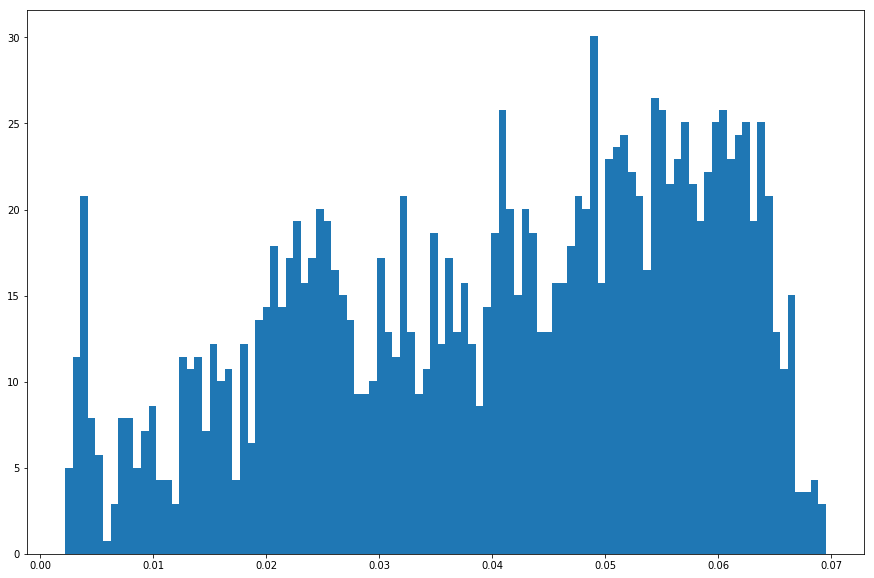

[0.00218158 0.00242474 0.00261293 0.00264085 0.00264085 0.0027308
 0.00277693 0.00301454 0.00304177 0.00315927 0.00318505 0.00322254
 0.00322479 0.00327167 0.00327254 0.00327254 0.00329363 0.00333418
 0.00337492 0.00342801 0.00347312 0.00352081 0.00352265 0.00356717
 0.00357464 0.00359031 0.00369755 0.0037226  0.00373518 0.00373833
 0.00374439 0.0037697  0.0037851  0.0037878  0.00378927 0.00379049
 0.00380572 0.00381286 0.00382273 0.00384922 0.00385643 0.00385643
 0.00385643 0.00386888 0.00387687 0.0039608  0.00398221 0.00398221
 0.00398221 0.00398757 0.0041498  0.00416223 0.00423159 0.0043057
 0.00443477 0.0044563  0.00447061 0.00447539 0.0044782  0.00451831
 0.00452228 0.00457328 0.00467176 0.00489505 0.00514995 0.00518093
 0.00531348 0.00533422 0.00538601 0.0054336  0.00544811 0.00604552
 0.006648   0.00683069 0.00686317 0.00686952 0.00699432 0.00703794
 0.00704523 0.00706266 0.00717746 0.00721618 0.00722982 0.00723023
 0.00729038 0.00739584 0.00749569 0.00766689 0.00769246 0.007803

In [75]:
p_vals = norm.pdf(z_scores, par[2], par[3])

plt.figure(figsize=(15, 10))
plt.hist(p_vals, bins=100, density=True)
plt.show()
print(p_vals)
